# Neural Network for Predicting Bike Rental using Neural Network

The exploratory data analysis and methodology for other prediction models (including regression, random forest, gradient boosting) can be found in the primary jupyter notebook: hubway-bikeshare-prediction.ipynb. 

Guidance on methodology taken from Udacity's Deep Learning course "First Neural Network": https://github.com/udacity/deep-learning

Great explanation by Welch Labs from youtube series "Neural Networks Demystified": https://www.youtube.com/watch?v=bxe2T-V8XRs

In [14]:
# Import Libraries 

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

%matplotlib inline

## Load and Prepare Data

In [3]:
# Build dataset for prediction models

trips_path = '/Users/lxu213/data/hubway-bikeshare-prediction/Trips_2016/'
trips = pd.DataFrame.from_csv(trips_path + '2016-tripdata.csv', index_col=1)

Eliminate categorical features using one-hot encoding.

In [6]:
# Data processing to prepare for prediction models

# subscriber, customer, and total ridership
trip = trips.loc[:, ['usertype']]
trip = trip.rename(columns={'usertype': 'subscriber'})
trip['customer'] = pd.Series(trip['subscriber'], index=trip.index)
trip['count'] = pd.Series(1, index=trip.index)

def convert_subscriber(row):
    return 1 if row == 'Subscriber' else 0
def convert_customer(row):
    return 1 if row == 'Customer' else 0

trip['subscriber'] = trip['subscriber'].apply(lambda row: convert_subscriber(row))  # apply function down rows
trip['customer'] = trip['customer'].apply(lambda row: convert_customer(row))

trip = trip.resample('1H', how='sum')        # sample series into 1 hour bins, sum count into bins
trip = trip.fillna(0)                        # fill hours with no rides

# add day of week, hour, month
def convert_weekday(row):
    return 1 if row in (0,1,2,3,4) else 0
trip['weekday'] = pd.Series(trip.index.dayofweek, index=trip.index)
trip['weekday'] = trip['weekday'].apply(lambda row: convert_weekday(row))
trip['hour'] = trip.index.hour
trip['month'] = trip.index.month

# add season
def is_season(row):
    if row in (12,1,2):
        return 0
    if row in (3,4,5):
        return 1
    if row in (6,7,8):
        return 2
    else:
        return 3
trip['season'] = pd.Series(trip.index.month, index=trip.index)
trip['season'] = trip['season'].apply(lambda row: is_season(row))

# holiday
holidays = calendar().holidays(start='2016-01-01', end='2016-12-31').to_pydatetime()
def is_holiday(row):
    return 1 if row in holidays else 0
trip['holiday'] = pd.Series(trip.index, index=trip.index)   
trip['holiday'] = trip['holiday'].apply(lambda row: is_holiday(row))

Incorporate climatological data.

In [7]:
# join climate data: rain, snow, temp
climate = pd.DataFrame.from_csv('/Users/lxu213/data/hubway-bikeshare-prediction/Climate_2016.csv', index_col=2)
climate_features = ['PRCP', 'AWND', 'SNOW', 'TAVG', 'TMAX', 'TMIN']
trip = trip.join(climate.set_index(climate.index.date).loc[:, climate_features], on=trip.index.date)
trip = trip.rename(columns={'PRCP': 'rain', 'AWND': 'wind', 'SNOW': 'snow', 
                            'TAVG': 'temp', 'TMAX': 'tmax', 'TMIN': 'tmin'})

# rearranging columns of dataframe
cols = trip.columns.tolist()
cols = cols[3:] + cols[:3]
trip = trip[cols]
trip[:5]

,weekday,hour,month,season,holiday,rain,wind,snow,temp,tmax,tmin,subscriber,customer,count
starttime,,,,,,,,,,,,,,
2016-01-01 00:00:00,1,0,1,0,1,0,12.75,0,39,41,33,12,1,13
2016-01-01 01:00:00,1,1,1,0,0,0,12.75,0,39,41,33,10,4,14
2016-01-01 02:00:00,1,2,1,0,0,0,12.75,0,39,41,33,8,1,9
2016-01-01 03:00:00,1,3,1,0,0,0,12.75,0,39,41,33,1,0,1
2016-01-01 04:00:00,1,4,1,0,0,0,12.75,0,39,41,33,0,0,0


### Convert Categorical Variables 
Since we have some categorical variables like season, month, and weekday we can convert them into binary dummy variables for use in model. Let's use get_dummies() in pandas.

In [8]:
dummy_fields = ['weekday', 'hour', 'month', 'season']
for each in dummy_fields:
    dummies = pd.get_dummies(trip[each], prefix=each)
    trip = pd.concat([trip, dummies], axis=1)

trip = trip.drop(dummy_fields, axis=1)
trip[:1]

,holiday,rain,wind,snow,temp,tmax,tmin,subscriber,customer,count,...,month_7,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3
starttime,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1,0,12.75,0,39,41,33,12,1,13,...,0,0,0,0,0,0,1,0,0,0


### Scale Target Variables
To make training the network easier, each of the continuous variables will be standardized by shifting and scaling the variables so that they have zero mean and a standard deviation of 1. The scaling factors are saved so later the network can use them for predictions.


In [9]:
quant_features = ['subscriber', 'customer', 'count', 'rain', 'wind', 'snow', 'temp','tmax','tmin']

# Store scalings in a dictionary to convert back later
scaled_features = {}
for each in quant_features:
    mean, std = trip[each].mean(), trip[each].std()
    scaled_features[each] = [mean, std]
    trip.loc[:, each] = (trip[each] - mean)/std
trip[:1]

,holiday,rain,wind,snow,temp,tmax,tmin,subscriber,customer,count,...,month_7,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3
starttime,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1,-0.375164,0.449701,-0.158044,-0.833163,-1.110868,-0.76366,-0.702639,-0.648348,-0.764272,...,0,0,0,0,0,0,1,0,0,0


### Split Data into Training, Testing, and Validation Sets
Split data into training set (60%), testing set (20%), and validation set (20%) using NumPy split() method. One set is for training and one set is for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [11]:
train, validate, test = np.split(trip.sample(frac=1), [int(.6*len(trip)), int(.8*len(trip))])

# separate data into features and targets
target_fields = ['count','subscriber', 'customer']
train_features, train_targets = train.drop(target_fields, axis=1), train[target_fields]
test_features, test_targets = test.drop(target_fields, axis=1), test[target_fields]
val_features, val_targets = validate.drop(target_fields, axis=1), validate[target_fields]

## Build Network
The network structure includes the backwards and forwards passes through the network. Hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is f(x)=x. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called forward propagation.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called backpropagation.



In [12]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes     # set no. of nodes in input, hidden and output layers.
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5,     # initialize weights
                                       (self.hidden_nodes, self.input_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        self.activation_function = lambda x: 1/(1.+np.exp(-x))              # activation function is sigmoid function
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T                           # convert inputs list to 2d array
        targets = np.array(targets_list, ndmin=2).T
        
        ### Forward Pass ###
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)        # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)            # signals from hidden layer
        
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)# signals into final output layer
        final_outputs = final_inputs                                        # signals from final output layer
        
        ### Backward Pass ###
        output_errors = targets-final_outputs                               # diff b/w desired target & actual output
        
        # backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors) # errors propagated to hidden layer
        hidden_grad = hidden_errors * hidden_outputs*(1.-hidden_outputs)    # hidden layer gradients
        
        # update weights with gradient descent step
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T) 
        self.weights_input_to_hidden += self.lr * np.dot(hidden_grad, inputs.T) 
 
    def run(self, inputs_list):                                             # run forward pass through network
        inputs = np.array(inputs_list, ndmin=2).T                           
        
        ### Forward Pass ###
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)        # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)            # signals from hidden layer
        
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)# signals into final output layer
        final_outputs = final_inputs                                        # signals from final output layer 
        
        return final_outputs

# Train Network
Set hyperparameters for the network such that the error on the training set is low and so we aren't overfitting the data. If networked is trained too long or have too many hidden nodes, it can become overly specific to the training set, overfit, and fail to generalize to the validation set. In other words, the loss on the validation set will start increasing as the training set loss drops.

This project uses stochastic gradient descent to train the network. This means that for each training pass, a random sample of data is used rather than the entire data set. More training passes will be used than in normal gradient descent, but each pass will be much faster. This ends up training the network more efficiently. 

### Number of Epochs
An epoch is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better at predicting the targets in the training set. Again, the number of epochs will need to be balanced between training the network well and overfitting. 

### Learning Rate
Learning rate scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A general strategy is to start the rate at 0.1 and reduce the learning rate if the network has problems fitting the data. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it will take for the neural network to converge.

### Number of Hidden Nodes
The more hidden nodes you have, the more accurate the model prediction will be. The losses dictionary is a good metric of the network performance. If there are too few hidden nodes, the model won't have enough space to learn and if there are too many, there are too many options for the direction that the learning can take. 

In [27]:
# set hyperparameters 
epochs = 500
learning_rate = 0.05
hidden_nodes = 30
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}              # losses dictionary
for e in range(epochs):                             # select random batch of 150 records from training set (SGD)
    batch = np.random.choice(train_features.index, size=150)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['count']): network.train(record, target)
    
    train_loss = MSE(network.run(train_features), train_targets['count'].values)  
    val_loss = MSE(network.run(val_features), val_targets['count'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "%     Training loss: " + str(train_loss)[:5] \
                     + "      Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
    

Progress: 99.8%     Training loss: 0.074      Validation loss: 0.086

(0.0, 1.0)

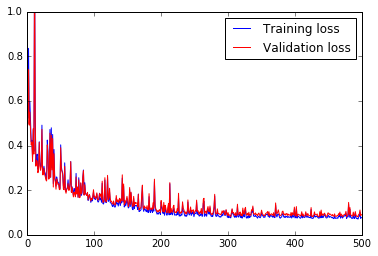

In [23]:
# plot results
plt.plot(losses['train'], label='Training loss', color='b')
plt.plot(losses['validation'], label='Validation loss', color='r')
plt.legend()
plt.ylim(ymax=1.0)


## Performance
Here we can use test data to gauge how well the neural network has performed. 

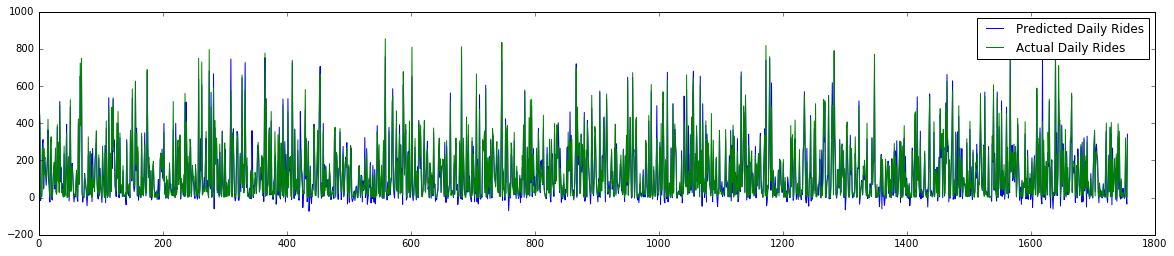

In [86]:
fig, ax = plt.subplots(figsize=(20,4))

mean, std = scaled_features['count']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Predicted Daily Rides')
ax.plot((test_targets['count']*std + mean).values, label='Actual Daily Rides')
ax.legend()


We can also look at some statistical measure for assessing accuracy.

In [55]:
# error functions
from math import sqrt

def mse(y, Y):
    return np.mean((y-Y)**2)

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [56]:
test_target = (test_targets['count']*std + mean).values
preds = predictions[0]

print 'MSE:', round(mse(test_target, preds), 2)
print 'RMSE:', round(sqrt(mse(test_target, preds)), 2)
print 'RMSLE:', round(rmsle(test_target, preds, False), 2)

MSE: 2016.57
RMSE: 44.91
RMSLE: 0.95
